# Node embedding using Graph Convolutional Network (GCN)

In [1]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
%matplotlib inline

## Graph embedding using PyG (PyTorch Geometric)

Follow these steps to install touch_geometric and its dependencies

```python
$conda create -n gml python=3.7
$conda activate gml
$conda install pytorch torchvision -c pytorch
$conda install torch_scatter
$conda install torch_sparse
$conda install torch_cluster
$conda install torch-spline-conv
$conda install tourch_geometric
$conda install osmnx

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

### Load the Cora dataset

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [4]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


#### Visualizing top 10 nodes with the highest degree of centrality in Cora dataset

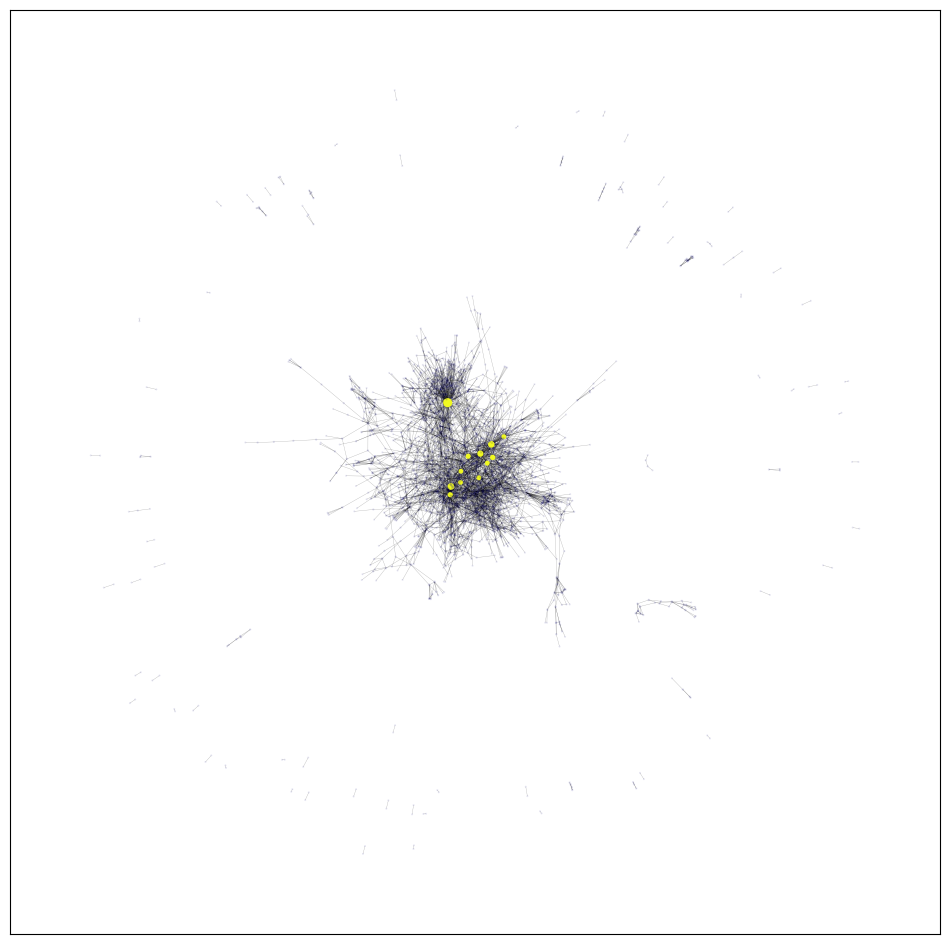

threshold 0.011821204285186553


In [5]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin, label=True)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()
# plt.savefig('Cora', dpi=300)
print("threshold", threshold)

### Create a two-layer GCN model

In [6]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x =  F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return x

 ### Train this model on the training nodes for 200 epochs

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
embeddings_pyg = model(data).detach().cpu().numpy()

print("Final Embeddings using GCN in PyG: ", embeddings_pyg)

Final Embeddings using GCN in PyG:  [[2257.5278 2242.3782 2225.4443 ... 2241.469  2202.1367 2236.4023]
 [3456.9275 3431.08   3406.676  ... 3433.349  3372.3398 3423.4312]
 [3515.5835 3490.167  3464.7083 ... 3491.1746 3428.9197 3481.8438]
 ...
 [1843.2476 1830.1469 1816.2375 ... 1829.2219 1797.3843 1825.539 ]
 [2476.7354 2459.7087 2441.2046 ... 2459.2087 2415.4595 2453.2974]
 [2331.14   2315.1465 2297.7424 ... 2314.5073 2273.501  2309.143 ]]


In [8]:
embeddings_pyg.shape

(2708, 7)

## Graph embedding using GCN in StellarGraph

<a href="https://stellargraph.readthedocs.io/en/stable/README.html">StellarGraph</a> is a Python library for machine learning on graphs and networks. To install stellargraph
```python
$pip install stellargraph

In [9]:
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras import Model

### Load the Cora dataset

In [10]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
graph, node_subjects = dataset.load()

In [11]:
# Print graph information
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [12]:
# Print node subjects and their counts
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


### Graph embedding

In [13]:
# Create a data generator to convert the core graph structure and node features into an embedding
# The generator encodes the information required to produce the model inputs.
# It will yield data appropriate for the GCN algorithm specifically, by using the normalized graph Laplacian matrix to capture the graph structure
generator = FullBatchNodeGenerator(graph, method="gcn")

Using GCN (local pooling) filters...


In [14]:
# Build the model with the following parameters:
# layer_sizes: the number of hidden GCN layers and their sizes. Two GCN layers are used with 16 units each.
# activations: the activation to apply to each GCN layer’s output. RelU is used for both layers.
# dropout: the rate of dropout for the input of each GCN layer.
    
gcn = GCN(
    layer_sizes=[16, len(set(node_subjects))], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [15]:
# Get input and output tensors of the GCN model
x_inp, x_out = gcn.in_out_tensors()
x_out

<KerasTensor: shape=(1, None, 7) dtype=float32 (created by layer 'gather_indices')>

In [16]:
# Create a model that computes/predicts embeddings
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [17]:
# Calling the flow method with a set of nodes aproduces an object that can be used to train the model on those nodes. 
all_gen = generator.flow(node_subjects.index)

In [18]:
# Compute embeddings for every node using the all_gen data.
embedding_stellar = embedding_model.predict(all_gen)
embedding_stellar.shape

1/1 [==============================] - 1s 590ms/step


(1, 2708, 7)

In [19]:
# Embeddings from the GCN model have a batch dimension of 1 so we squeeze this to get a matrix of node embeddings
embedding_stellar = embedding_stellar.squeeze(0)
embedding_stellar.shape

(2708, 7)

## Embedding Visualization

### Low dimension-reduction transform for visualization

In [20]:
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])

### Visualize PyG node embedding

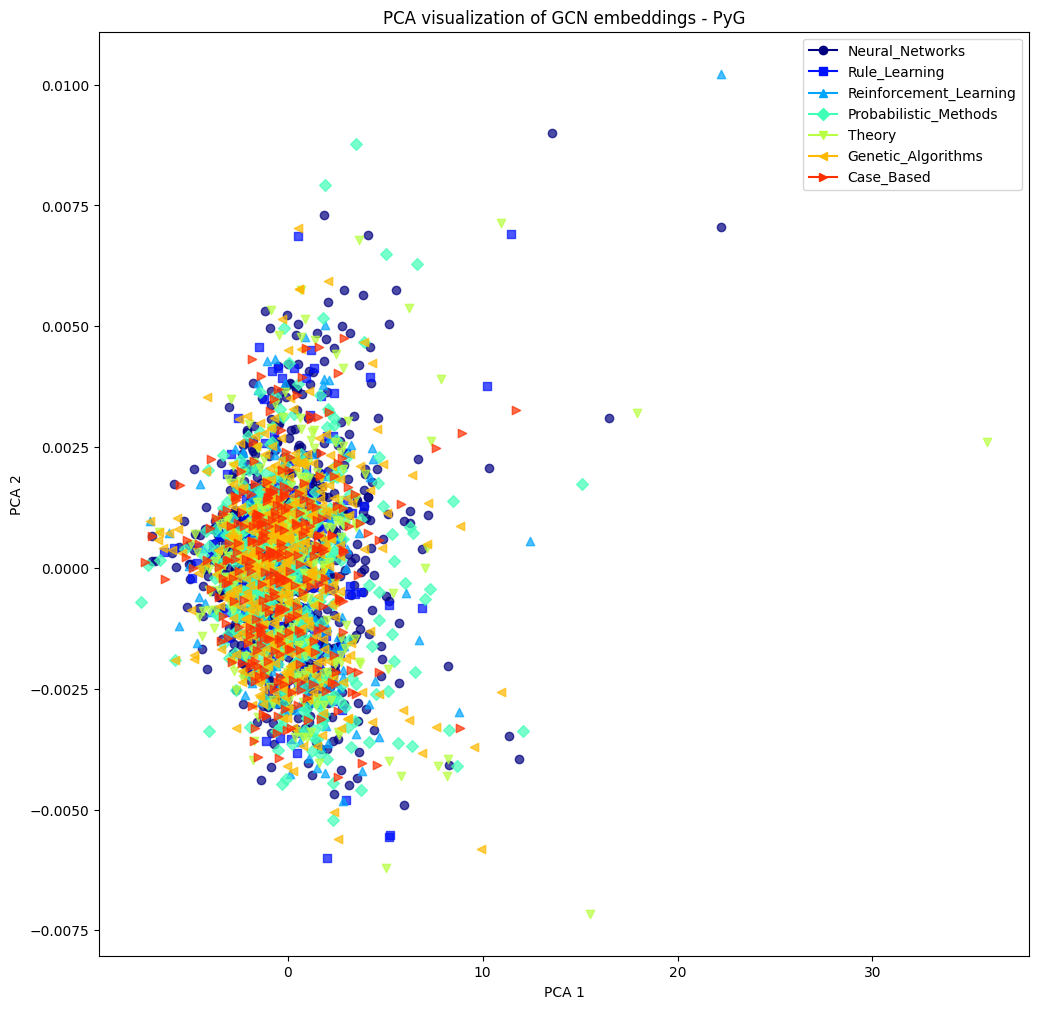

In [30]:
node_embeddings_2d = pipeline.fit_transform(embeddings_pyg)

# Get the class labels for each node
labels = data.y.cpu().numpy()

# Create a scatter plot of the 2-dimensional PCA embeddings
plt.figure(figsize=(12, 12))

markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'H']

for idx, subject in enumerate(node_subjects.unique()):
    class_labels = labels[node_subjects == subject]
    plt.scatter(node_embeddings_2d[node_subjects == subject, 0],
                node_embeddings_2d[node_subjects == subject, 1],
                color=plt.cm.jet(idx / len(node_subjects.unique())),
                alpha=0.7,
                marker=markers[idx])

# Adding legend
for idx, subject in enumerate(node_subjects.unique()):
    plt.plot([], [], marker=markers[idx], color=plt.cm.jet(idx / len(node_subjects.unique())), label=subject)

plt.legend(loc='upper right')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA visualization of GCN embeddings - PyG')
plt.show()
# plt.savefig('CH11_F08_PyG_embeddings.png', format='png', bbox_inches='tight', dpi=300)

### Visualize StellarGraph node embedding

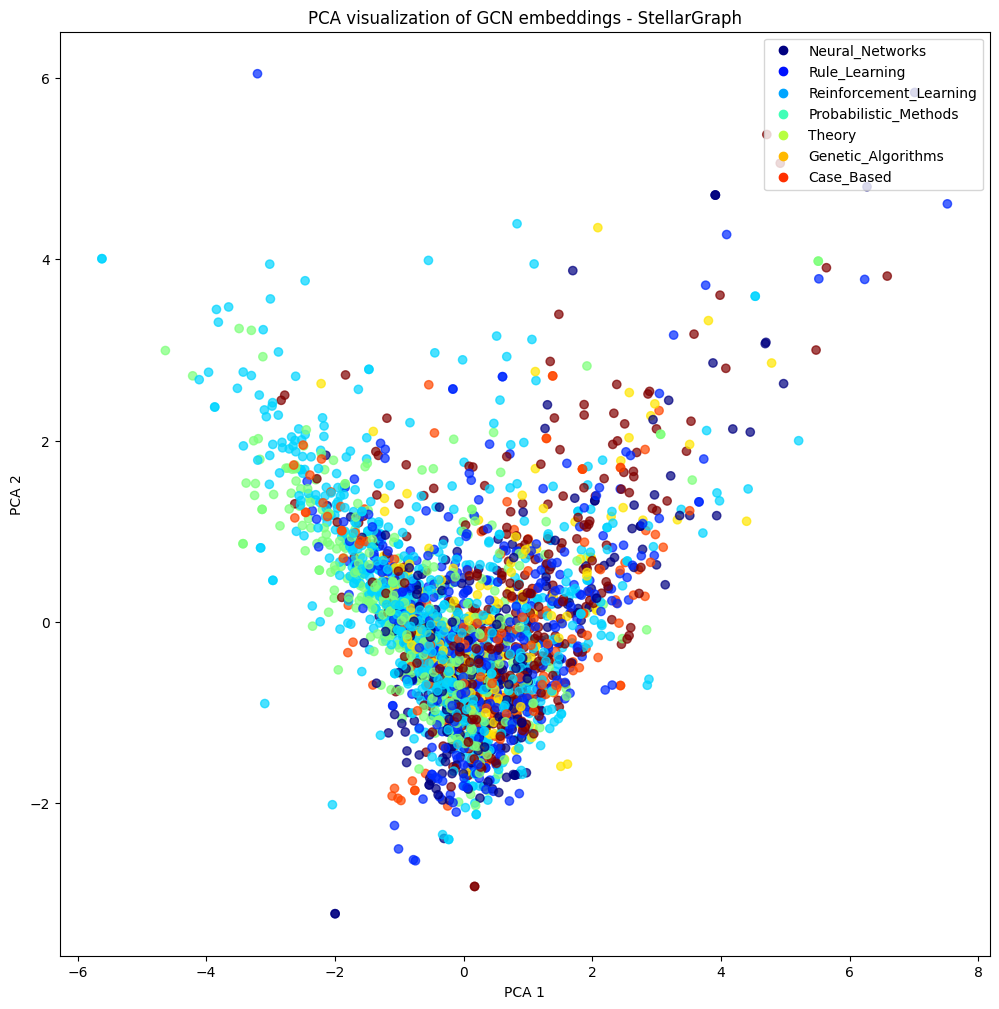

<Figure size 640x480 with 0 Axes>

In [27]:
X_reduced = pipeline.fit_transform(embedding_stellar)
X_reduced.shape

fig, ax = plt.subplots(figsize=(12, 12))

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=node_subjects.astype("category").cat.codes, cmap='jet', alpha=0.7)

# Adding legend
for subject in node_subjects.unique():
    color = plt.cm.jet(color_map[str(subject)] / len(node_subjects.unique()))
    plt.plot([], [], 'o', color=color, label=subject)

plt.legend(loc='upper right')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA visualization of GCN embeddings - StellarGraph')
plt.show()
plt.savefig('StellarGraph_embeddings.png', format='png', bbox_inches='tight', dpi=300)